# **🍽️ Yelp Restaurant Recommendation System: A Comparative Study**

## **I. Introduction**

### **i. Context**

**Yelp** was founded in **2004** to help people discover **great local businesses**. Today, its website and mobile app feature crowd-sourced reviews and business information designed to support customers in their **decision-making process**. Yelp employs automated software to highlight the **most helpful** and **reliable reviews** from its extensive and diverse dataset.

The Yelp dataset is a comprehensive collection of user reviews, business metadata, check-ins, social network data, and user tips for businesses across 10 cities in **4 countries**. The original dataset is quite large, totaling approximately 11GB. For this case study, we will work with a **subset of the data** due to hardware limitations.

### **ii. Objective**

In this case study, we will build three types of recommendation systems:
- **Knowledge/Rank Based recommendation system**
- **Similarity-Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**

### **iii. Data Dictionary**

From the many attributes available in the `yelp_reviews` dataset, we will focus on the following four:

- **business_id**: Unique identifier for each business  
- **business_name**: Name of the business  
- **stars**: Rating given by the user (usually 1–5)  
- **user_id**: Unique identifier for each user

### **iv. Libraries**

In [1]:
# I. ----- Introduction -----
# This chapter does not have Python code.

# II. ----- Data Overview -----
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# III. ----- Modelling -----
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering
from collections import defaultdict
import numpy as np

# Used to ignore the warning given as output of the code
#import warnings
#warnings.filterwarnings('ignore')




# A dictionary output that does not raise a key error

# A performance metrics in sklearn
#from sklearn.metrics import mean_squared_error

## **II. Data Pipeline**

### **i. Data Overview**

In [2]:
# Import the dataset
yelp_review = pd.read_csv('yelp_reviews.csv', usecols = ['user_id', 'business_id', 'business_name', 'stars'])
# Drop the "business_name" column
data = yelp_review.drop("business_name", axis = 1)

#### **1. Data Info**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  229907 non-null  object
 1   stars        229907 non-null  int64 
 2   user_id      229907 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


🔬 **Observations**

Based on the dataset summary:

- The dataset contains **229,907 entries** (rows) and **3 columns**.  
- All columns have **no missing values**, meaning the dataset is complete for the selected attributes.  
- **Column types**:  
  - `business_id`: object (string)  
  - `stars`: integer (ratings given by users)  
  - `user_id`: object (string)  
- The dataset occupies approximately **5.3 MB** of memory.  
- This dataset captures user ratings for businesses, which can be used for **analysis of business performance and user behavior**.

In [4]:
# First 5 rows
data.head()

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,5,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,4,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,5,uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,5,vYmM4KTsC8ZfQBg-j5MWkw


#### **2. Data Distribution**

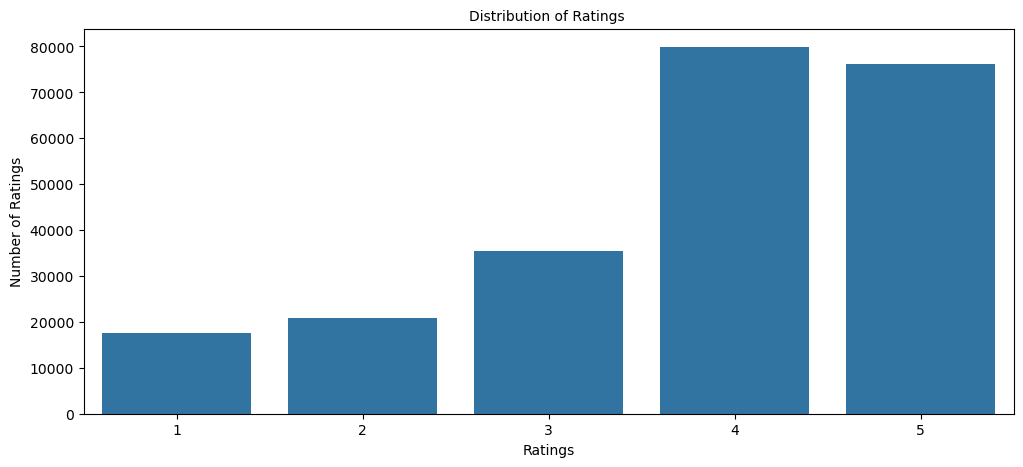

In [5]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x = "stars", data = data)
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

🔬 **Observations**

Based on the `stars` distribution:

- **1-star ratings**: 17,516  
- **2-star ratings**: 20,957  
- **3-star ratings**: 35,363  
- **4-star ratings**: 79,878  
- **5-star ratings**: 76,193  

**Key insights:**

- Most ratings are **4-star and 5-star**, indicating that users generally provide positive reviews.  
- 4-star ratings are the most common, slightly higher than 5-star ratings.  
- Lower ratings (1 and 2 stars) are comparatively less frequent, together making up less than 17% of all reviews.  
- This distribution is **right-skewed**, showing a trend of favorable user feedback for businesses.

#### **3. Unique Values**

In [6]:
# Number of unique users
data['user_id'].nunique()

45981

In [7]:
# Number of unique restaurants
data['business_id'].nunique()

11537

🔬 **Observations**
- There are **45,981 unique users** in the dataset.
- There are **11,537 unique restaurants** in the dataset.
- As per the number of unique users and restaurants, there is a **possibility of 45,981 * 11,537 = ~53 x 10^7 ratings** in the dataset. But **we only have 2,29,907 ratings**, i.e., not every user has rated every restaurant in the dataset. And we can build a recommendation system to recommend a restaurant to users which they have not visited.

#### **4. Same Restaurant Different User Ratings**

In [8]:
# Find the sum of total ratings count by each user restaurant pair
data.groupby(['user_id', 'business_id']).count()['stars'].sum()

229907

🔬 **Observations**

- The **sum is equal to the total number of observations** which implies **there is only interaction between a pair of restaurants and a user**.

#### **5. The Most Reviewed Restaurant**

In [9]:
data['business_id'].value_counts()

hW0Ne_HTHEAgGF1rAdmR-g    844
VVeogjZya58oiTxK7qUjAQ    794
JokKtdXU7zXHcr20Lrk29A    731
ntN85eu27C04nwyPa8IHtw    679
EWMwV5V9BxNs_U6nNVMeqw    645
                         ... 
1O4M8H5g3vdrzg9WcLeGsg      3
-JaNk2DOQdpjTl5Bu-iehg      3
hBhIdGHnOrybzw-VuGuBig      3
seMhyOy1AHHE1_ZLm2R_BQ      3
OsBdaxPwMOeeH-8uGpJDZA      3
Name: business_id, Length: 11537, dtype: int64

🔬 **Observations**

Based on the `business_id` distribution:

- The dataset contains **11,537 unique businesses**.  
- The number of reviews per business varies widely:  
  - The most-reviewed business has **844 reviews**.  
  - Several businesses have very few reviews, with some having only **3 reviews**.  
- **Top-reviewed businesses** have hundreds of reviews, indicating high popularity or frequent customer engagement.  
- Most businesses have relatively few reviews, suggesting a **long-tail distribution** where a small number of businesses receive a large portion of reviews.  
- This distribution can impact analysis: businesses with few reviews may have **less reliable average ratings** compared to those with many reviews.

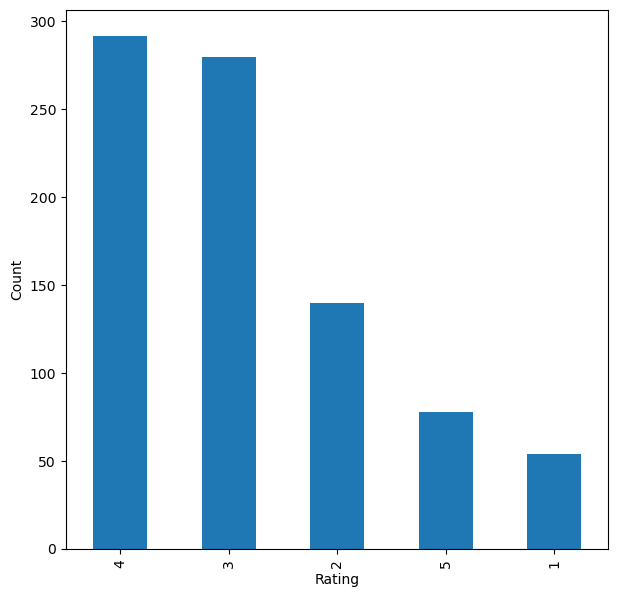

In [10]:
plt.figure(figsize = (7, 7))
data[data['business_id'] == "hW0Ne_HTHEAgGF1rAdmR-g"]['stars'].value_counts().plot(kind = 'bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

🔬 **Observations**

- We can see that **this restaurant is not liked by many of the users**, as the count of ratings 3 and 4 is higher than the count of other ratings.
- There can be restaurants with very high interactions but the count of ratings **1 and 2** may be much higher than **4 or 5** which would imply that the restaurant is disliked by the majority of the users.

#### **6. User with the Most Restaurant Visits**

In [11]:
data['user_id'].value_counts()

fczQCSmaWF78toLEmb0Zsw    588
90a6z--_CUrl84aCzZyPsg    506
0CMz8YaO3f8xu4KqQgKb9Q    473
4ozupHULqGyO42s3zNUzOQ    442
joIzw_aUiNvBTuGoytrH7g    392
                         ... 
B0_ToavrQMU3BvuQtxUW3w      1
-JaGS3JW1ObiTAvSoSFsAg      1
hf4t4rFs9MO4n0jfvDSpTA      1
qdB_t0cm0vk6v4kXrkECSw      1
LPfJa06Ce_4S8daGvPG_eg      1
Name: user_id, Length: 45981, dtype: int64

🔬 **Observations**

- The user with **user_id fczQCSmaWF78toLEmb0Zsw** has interacted with the most number of restaurants, i.e., **588** times.
- But still, there is a possibility of **11,537-588 =  10,949** more interactions as we have **11,537 unique restaurants** in our dataset. For those **10,949** remaining restaurants, we can build a recommendation system to predict which restaurants are most likely to be reviewed by this user.

### **ii. Data Preparation**

In [12]:
# Get the column containing the users
users = data.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [13]:
RATINGS_CUTOFF = 100
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = data.loc[ ~ data.user_id.isin(remove_users)]

## **III. Modelling**

### **i. Model 1: Rank-Based Recommendation System**

A **rank-based recommendation system** provides suggestions based on the **most popular items**. This approach is particularly useful in **cold start** scenarios.  

A cold start occurs when a **new user joins the system** and there is no historical interaction data available. In such cases, the system cannot generate personalized recommendations. To address this, a rank-based recommendation system can suggest restaurants based on overall popularity, ensuring that the new user still receives meaningful recommendations despite the lack of personal history.

In [14]:
# Calculate average ratings
average_rating = data.groupby('business_id')['stars'].mean()
# Calculate the count of ratings
count_rating = data.groupby('business_id')['stars'].count()
# Make a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [15]:
# First 5 records of the final_rating
final_rating.head()

,avg_rating,rating_count
business_id,,
--5jkZ3-nUPZxUvtcbr8Uw,4.545455,11
--BlvDO_RG2yElKu9XA1_g,4.162162,37
-0D_CYhlD2ILkmLR0pBmnA,4.000000,5
-0QBrNvhrPQCaeo7mTo0zQ,4.333333,3
-0bUDim5OGuv8R0Qqq6J4A,2.333333,6


**Function Preparation**

In [16]:
def top_n_restaurant(data, n, min_interaction = 100):
    """
    Returns the top N restaurants based on average ratings, considering only restaurants
    that have a minimum number of user interactions.    

    Parameters
    ----------
    data : pandas.core.frame.DataFrame
        A DataFrame containing restaurant information, which must include:
        - 'avg_rating': Average rating of the restaurant
        - 'rating_count': Number of ratings or interactions for the restaurant
    n : int
        The number of top restaurants to return.
    min_interaction : int, optional
        Minimum number of user interactions (ratings) required for a restaurant 
        to be considered. Defaults to 100.

    Returns
    -------
    pandas.core.indexes.base.Index
        Index of the top N restaurants sorted by average rating in descending order.

    """
    
    # Finding restautants with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

**Top 5 Restaurant with 50 Minimum Interactions Based on Popularity.**

In [17]:
list(top_n_restaurant(final_rating, 5, 50))

['8HQ8clouLGgee99KkR4vXA',
 'CKjcewWeWvdJ7TzOQbZOIw',
 '97Z7j4vH0kfzL10AONi4uA',
 '_TekkyyFeX_8MBepPIxuTg',
 'L-uPZxooP_ziXCtRrWi8Pw']

### **ii. Model 2: Collaborative Filtering Based Recommendation System**

In a **collaborative recommendation system**, we **do not need any information** about the users or items themselves. The system relies solely on **user–item interaction data** to make recommendations.  

Examples of user–item interactions include:

1. **Ratings**: For instance, ratings of books on Goodreads or movies on IMDb.  
2. **Likes**: Likes on Facebook posts or YouTube videos.  
3. **Usage or Purchases**: Items bought by users on e-commerce platforms.  
4. **Reading**: Articles read by users on blogs or news websites.

There are two types of collaborative filtering:

- Similarity/Neighborhood-based
    - User-User Similarity-Based
    - Item-Item Similarity-based
- Model based

#### **1. Function Preparation**

In [18]:
def precision_recall_at_k(model, k=10, threshold=3.5):
    """
    Computes the **Precision@K**, **Recall@K**, and **F1 score** for a recommendation model
    using the predicted ratings for the test set.

    Parameters
    ----------
    model : surprise.prediction_algorithms.knns.KNNBasic
        A trained recommendation model that has a `.test()` method for generating predictions.
    k : int, optional
        The number of top items to consider for evaluating precision and recall. Default is 10.
    threshold : float, optional
        The rating threshold above which an item is considered relevant. Default is 3.5.

    Returns
    -------
    None
        Prints the overall **Precision@K**, **Recall@K**, and **F1 score** for the model.
    
    Notes
    -----
    - Precision@K measures the proportion of recommended items in the top-K that are relevant.
    - Recall@K measures the proportion of relevant items that appear in the top-K recommendations.
    - F1 score is the harmonic mean of precision and recall.
    - Users with no relevant or recommended items are assigned a precision or recall of 0.
    """
    
    # First map the predictions to each user
    user_est_true = defaultdict(list)
    # Making predictions on the test data
    predictions = model.test(testset)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        # Precision@K: Proportion of recommended items that are relevant. When n_rec_k is 0,
        # Precision is undefined. We here set Precision to 0 when n_rec_k is 0
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended. When n_rel is 0,
        # Recall is undefined. We here set Recall to 0 when n_rel is 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)
    # Command to print the overall recall
    print('Recall: ', recall)
    # Formula to compute the F-1 score
    print('F_1 score: ', round((2*precision * recall) / (precision + recall), 3))

#### **2. Data Preparation**

In [19]:
# Instantiate Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# Load the dataset
data = Dataset.load_from_df(df_final[['user_id', 'business_id', 'stars']], reader)
# Splitt the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

#### **3. Baseline User-User Similarity Based Recommendation System**

In [20]:
# Declare the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}
# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)
# Train the algorithm on the train set, and predict ratings for the testset
sim_user_user.fit(trainset)
# Compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 1.0409
Precision:  0.773
Recall:  0.417
F_1 score:  0.542


🔬 **Observations**

- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.
- Intuition of Recall - We are getting a **recall of almost 0.42**, which means out of **all the relevant restaurants, 42% are recommended**.
- Intuition of Precision - We are getting a **precision of almost 0.773**, which means **out of all the recommended restaurants 77.3% are relevant**.
- Here **F_1 score** of the **baseline model is almost 0.542**. It indicates that **mostly recommended restaurants were relevant and relevant restaurants were recommended** to the user. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

#### **4. Prediction**

In [21]:
# Predict rating for a sample user with a visited restaurant
sim_user_user.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.77   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

🔬 **Observations**

- The above output shows that **the actual rating for this user-item pair is 5 and the predicted rating is 3.77** by the **user-user-similarity-based baseline model**. This implies that the model is under-estimating the ratings.

Below is the function to find the **list of users who have not seen the restaurant with business id "9yKzy9PApeiPPOUJEtnvkg"**.

In [22]:
def n_users_not_interacted_with(n, data, business_id):
    """
    Returns a list of users who have **not interacted** with a given business.

    Parameters
    ----------
    n : int
        Number of users to return.
    data : pandas.core.frame.DataFrame
        A DataFrame containing user–business interaction data. It must include
        the columns:
        - 'user_id'
        - 'business_id'
    business_id : str
        The unique identifier of the business for which non-interacting users
        are to be identified.

    Returns
    -------
    list
        A list of `n` user IDs who have not interacted with the specified business.
    """
    
    users_interacted_with_product = set(data[data['business_id'] == business_id]['user_id'])
    all_users = set(data['user_id'])

    return list(all_users.difference(users_interacted_with_product))[:n]

In [23]:
n_users_not_interacted_with(5, df_final, '9yKzy9PApeiPPOUJEtnvkg')

['KucBnMrhalzxnD9AWrxwYQ',
 'sEWeeq41k4ohBz4jS_iGRw',
 'eBwBjylS66qPcHs2_ajLag',
 'CP-IE-zyc2Mv3jlaceElVQ',
 '64YY0h0ZAR2nbzxbx0IwJg']

🔬 **Observations**

Below we are **predicting rating for the  `userId = 4UUIpbOTPmu43wuC2aSGkg` but for a restaurant which this user has not seen yet, i.e., `business_id = 9yKzy9PApeiPPOUJEtnvkg`**

In [24]:
# Predict rating for a sample user with a restaurant that is not-visited by the user
sim_user_user.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.76   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.7589814527944565, details={'actual_k': 16, 'was_impossible': False})

#### **5. Optimization Using Hyper-Parameter Tuning**

In [25]:
# Set up the parameters grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Perform 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fit the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])
# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0148311301812638
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}


#### **6. Final Model**

In [26]:
# Use the optimal similarity measure for user-user-based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}
# Create an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)
# Train the algorithm on the train set
sim_user_user_optimized.fit(trainset)
# Compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0060
Precision:  0.762
Recall:  0.413
F_1 score:  0.536


🔬 **Observations**

- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model has reduced a bit as compared to the baseline model.**

#### **7. Prediction**

In [27]:
sim_user_user_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.77   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

In [28]:
sim_user_user_optimized.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.76   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.7589814527944565, details={'actual_k': 16, 'was_impossible': False})

#### **8. Similar Users to a Given User (Nearest Neighbors)**

In [29]:
sim_user_user_optimized.get_neighbors(0, 5)

[18, 52, 79, 97, 103]

#### **9. Recommendation Algorithm Based on Optimized KNNBasic Model**

Below we will be implementing a function where the input parameters are -

- data: A **rating** dataset.
- user_id: A user id **for which we want the recommendations**.
- top_n: The **number of items we want to recommend**.
- algo: The algorithm we want to use **for predicting the ratings**.
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm.

In [30]:
# First 5 records of the df_final dataframe
df_final.head()

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q
6,zp713qNhx8d9KCJJnrw1xA,5,wFweIWhv2fREZV_dYkz_1g
13,WGNIYMeXPyoWav1APUq7jA,4,Xm8HXE1JHqscXe5BKf0GFQ
18,b5cEoKR8iQliq-yT2_O0LQ,3,UsULgP4bKA8RMzs8dQzcsA
19,4JzzbSbK9wmlOBJZWYfuCg,4,nDBly08j5URmrHQ2JCbyiw


#### **10. Function Preparation**

In [31]:
def get_recommendations(data, user_id, top_n, algo):
    """
    Generates personalized restaurant recommendations for a given user using
    a collaborative filtering algorithm.

    Parameters
    ----------
    data : pandas.core.frame.DataFrame
        A DataFrame containing user–restaurant interaction data with at least
        the following columns:
        - 'user_id'
        - 'business_id'
        - 'stars'
    user_id : str
        The unique identifier of the user for whom recommendations are generated.
    top_n : int
        The number of top recommendations to return.
    algo : surprise.prediction_algorithms.knns.KNNBasic
        A trained recommendation algorithm (e.g., from the Surprise library)
        that supports the `predict(user_id, item_id)` method.

    Returns
    -------
    list
        A list of tuples in the form `(business_id, predicted_rating)`, containing
        the top `top_n` restaurants recommended for the given user, sorted by
        predicted rating in descending order.
    """

    # Create an empty list to store the recommended restaurant ids
    recommendations = []
    # Create an user item interactions matrix
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'business_id', values = 'stars')
    # Extract those restaurant ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    # Loop through each of the restaurant ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        # Predict the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        # Append the predicted ratings
        recommendations.append((item_id, est))
    # Sort the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Return top n highest predicted rating restaurants for this user
    return recommendations[:top_n]

#### **11.1 Top 5 Business/Product (`userId` = rLtl8ZkDX5vH5nAx9C3q5Q)**

In [32]:
# Top 5 recommendations for user_id "rLtl8ZkDX5vH5nAx9C3q5Q" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_user_user)

In [33]:
# Build the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,5
1,-7XuLxfYwZ9x72mEKXdv0A,5
2,-A82xEVAjOYZtDdRQw1FQw,5
3,-CZ78c-H3tTxpP-uQ09CWw,5
4,-J0jhpG0rv4saq9OMh8gXw,5


#### **11.2 Ratings and Ranking Correction**

In [34]:
def ranking_products(recommendations, final_rating):
    """
    Ranks recommended businesses by adjusting predicted ratings using the
    number of user interactions to improve reliability.

    Parameters
    ----------
    recommendations : list
        A list of recommended businesses in the form
        `(business_id, predicted_rating)`.
    final_rating : pandas.core.frame.DataFrame
        A DataFrame containing aggregated business-level statistics, indexed
        by `business_id`, and including at least:
        - 'rating_count': Total number of ratings for each business.

    Returns
    -------
    ranked_products : pandas.core.frame.DataFrame
        A DataFrame containing the recommended businesses ranked by
        **corrected ratings**, which penalize businesses with fewer ratings.
        The output includes:
        - business_id
        - rating_count
        - predicted_ratings
        - corrected_ratings
    """
    
    # Sort the products based on ratings count
    ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()
    # Merge with the recommended businesses to get predicted ratings
    ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings']), on = 'business_id', how = 'inner')
    # Rank the businesses based on corrected ratings
    ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])
    # Sort the businesses based on corrected ratings
    ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)

    return ranked_products

In [35]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,11,5,4.698489
1,-J0jhpG0rv4saq9OMh8gXw,6,5,4.591752
2,-7XuLxfYwZ9x72mEKXdv0A,5,5,4.552786
3,-A82xEVAjOYZtDdRQw1FQw,5,5,4.552786
4,-CZ78c-H3tTxpP-uQ09CWw,3,5,4.422650


### **iii. Model 3: Item Item Collaborative Filtering Model**

In [36]:
# Declare the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)
# Train the algorithm on the train set, and predict ratings for the testset
sim_item_item.fit(trainset)
# Compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0218
Precision:  0.663
Recall:  0.344
F_1 score:  0.453


**🔬 Observations**

- The baseline model is giving an F_1 score of **about 45%**. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

#### **1. Prediction**

Use `userId = rLtl8ZkDX5vH5nAx9C3q5Q` and `business_Id = 9yKzy9PApeiPPOUJEtnvkg`. The user has already interacted or visited the restaurant with businessId "9yKzy9PApeiPPOUJEtnvkg".

In [37]:
# Predict rating for a sample user with a visited restaurant
sim_item_item.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.48   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.475, details={'actual_k': 40, 'was_impossible': False})

Use `userId = 4UUIpbOTPmu43wuC2aSGkg` but for a restaurant which this user has not visited yet, i.e., `business_id = 9yKzy9PApeiPPOUJEtnvkg`**

In [38]:
# Predict rating for a sample user with restaurant not visited by the user
sim_item_item.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.52   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.522856355785702, details={'actual_k': 40, 'was_impossible': False})

#### **2. Optimization Using Hyper-Parameter Tuning**

In [39]:
# Set up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Perform 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fit the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])
# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0102144253238852
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


#### **3. Final Model**

In [40]:
# Use the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}
# Create an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)
# Train the algorithm on the train set
sim_item_item_optimized.fit(trainset)
# Compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9986
Precision:  0.708
Recall:  0.375
F_1 score:  0.49


**🔬 Observations**

- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is much better than the baseline model**. Also, there is a considerable fall in the RMSE value after tuning the hyperparameters. Hence the tuned model is doing better than the earlier one.

#### **4. Prediction**

Let's us now predict **rating for an user with `userId = rLtl8ZkDX5vH5nAx9C3q5Q` and for `business_id = 9yKzy9PApeiPPOUJEtnvkg`** with the **optimized model** as shown below.

In [41]:
sim_item_item_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.90   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.896024464831805, details={'actual_k': 30, 'was_impossible': False})

**🔬 Observations**
- Here the optimized model is predicting a good rating (almost **4.90**) for the business whose actual rating is 5.

Below we are **predicting rating** for the **`userId = 4UUIpbOTPmu43wuC2aSGkg`** but for a restaurant which this user **has not visited before**, i.e., `business_id == 9yKzy9PApeiPPOUJEtnvkg`, by using the optimized model as shown below -

In [42]:
sim_item_item_optimized.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.57   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.5702603445087346, details={'actual_k': 30, 'was_impossible': False})

**🔬 Observations**
- For an unknown business the model is predicting a rating of **3.57**.

#### **5. Similar Items to a Given Item (Nearest Neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar items to the item with internal id 0 based on the `msd` distance metric

In [43]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[21, 27, 35, 51, 57]

#### **6. Top 5 Business/Product (userId = "rLtl8ZkDX5vH5nAx9C3q5Q")**

In [44]:
# Top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q with similarity-based recommendation engine
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_item_item_optimized)

In [45]:
# Build the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,5Q49MxuWJgXS649i7i2Iow,4.416667
1,SmY_Xw31b2xyzsKbimQiHQ,4.346154
2,N6ff0yyo9Cv_7XPz-YDoow,4.308696
3,UmFnmIoLCRe1ywY0bzpRrQ,4.307692
4,p204PQg45gECcYwxCAK1wA,4.307692


In [46]:
# Apply the ranking_products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
1,5Q49MxuWJgXS649i7i2Iow,10,4.416667,4.100439
0,SmY_Xw31b2xyzsKbimQiHQ,15,4.346154,4.087955
2,N6ff0yyo9Cv_7XPz-YDoow,7,4.308696,3.930731
3,UmFnmIoLCRe1ywY0bzpRrQ,4,4.307692,3.807692
4,p204PQg45gECcYwxCAK1wA,3,4.307692,3.730342


**🔬 Observations**

- Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **iv. Model 4: Matrix Factorization**

#### **1. Baseline Matrix Factorization Using Singular Value Decomposition (SVD)**

In [47]:
# SVD matrix factorization
svd = SVD(random_state = 1)
# Train the algorithm on the train set
svd.fit(trainset)
# Compute precision@k and recall@k with k = 10
precision_recall_at_k(svd)

RMSE: 0.9630
Precision:  0.77
Recall:  0.383
F_1 score:  0.512


**🔬 Observations**

- The baseline model with the algorithm is giving a nice F-1 score (almost **51%**). It indicates a good performance by the model.

- Let's now predict the rating for a user with **`userId = "rLtl8ZkDX5vH5nAx9C3q5Q`"** and **`business_id = "9yKzy9PApeiPPOUJEtnvkg"`** as shown below. Here the user has already rated..

#### **2. Prediction**

In [48]:
# Prediction
svd.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.16   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.155179595069889, details={'was_impossible': False})

As we can see - **the actual rating** for this user-item pair is 5 and the predicted rating is also close to that. It seems like we have under-estimated the rating. We will try to fix this later by **tuning the hyperparameters** of the model using GridSearchCV.

Below we are predicting rating for the `userId = 4UUIpbOTPmu43wuC2aSGkg` but for a restaurant which this user has not seen before, i.e., `business_id = 9yKzy9PApeiPPOUJEtnvkg`, as shown below -

In [49]:
# Making prediction using the svd model
svd.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.40   {'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.400759810167593, details={'was_impossible': False})

#### **3. Optimization Using Hyper-Parameter Tuning**

We are tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SVD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [50]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Perform 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fit the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9583483406773393
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


#### **4. Final Model**

In [51]:
# Build the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)
# Train the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)
# Compute precision@k and recall@k also with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.9507
Precision:  0.79
Recall:  0.402
F_1 score:  0.533


**🔬 Observations**

- We can see from above that the **tuned model** is showing a slightly better F_1 score than the baseline model, also the RMSE has gone down. Hence the tuned model is doing better than the earlier model.

Let's now predict a rating for a user with `userId = rLtl8ZkDX5vH5nAx9C3q5Q` and `BusinessId = 9yKzy9PApeiPPOUJEtnvkg` with the optimized model as shown below.

In [52]:
svd_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.91   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.90754419377377, details={'was_impossible': False})

**🔬 Observations**

- The predicted rating is good here for a restaurant whose actual rating is **5**. The optimized model is giving a fairly good prediction.

In [53]:
svd_optimized.predict("4UUIpbOTPmu43wuC2aSGkg", "9yKzy9PApeiPPOUJEtnvkg", verbose = True)

user: 4UUIpbOTPmu43wuC2aSGkg item: 9yKzy9PApeiPPOUJEtnvkg r_ui = None   est = 3.53   {'was_impossible': False}


Prediction(uid='4UUIpbOTPmu43wuC2aSGkg', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=None, est=3.5317237183975245, details={'was_impossible': False})

**🔬 Observations**
- For an unseen restaurant the rating given by the optimized model seems to be fine.

#### **5. Result**

In [54]:
# Getting top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, svd_optimized)

In [55]:
# Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
1,X3icXUyW9vS4UXY6V_MR4w,79,4.764319,4.651811
0,GwSdGrvaXi4BdXNSWKn-EA,153,4.645138,4.564293
2,97Z7j4vH0kfzL10AONi4uA,78,4.637496,4.524268
3,XRBTHOXaJK_AJ2wy5mX_1A,26,4.622570,4.426454
4,4SviSw8uRF0ddj_HxUVnuA,10,4.623874,4.307647


## **IV. Conclusion**

In this case study, we developed recommendation systems using **five different algorithms**, including:

- **Rank-based recommendation** using average ratings  
- **User–user similarity–based collaborative filtering**  
- **Item–item similarity–based collaborative filtering**  
- **Model-based collaborative filtering** using **matrix factorization**

Each approach differs in terms of the **type of data required**, the **assumptions made**, and the **kind of recommendations produced**. We explored these differences to understand when each technique is most appropriate. Additionally, we discussed how multiple recommendation techniques can be **combined** to build more robust and effective recommendation systems.

To implement **user–user similarity–based**, **item–item similarity–based**, and **model-based (matrix factorization)** collaborative filtering methods, the **Surprise** library was used. For each algorithm, **grid search cross-validation** was applied to identify the best-performing model, and the optimized models were then used to generate predictions.

For **performance evaluation**, the metrics **Precision@K** and **Recall@K** were introduced and calculated for each model. Using these metrics, the **F₁ score** was computed to provide a balanced measure of model performance across precision and recall.